In [7]:
# # data collection
# import pandas_datareader as pdr
# df = pdr.get_data_tiingo('AAPL',api_key='key')
# df.to_csv('AAPL.csv')

In [8]:
import pandas as pd
df=pd.read_csv('AAPL.csv')
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,AAPL,2015-07-20 00:00:00+00:00,132.07,132.97,130.70,130.97,58900203,121.705596,122.534967,120.443109,120.691920,58900203,0.0,1.0
1,AAPL,2015-07-21 00:00:00+00:00,130.75,132.92,130.32,132.85,76756427,120.489185,122.488891,120.092930,122.424384,76756427,0.0,1.0
2,AAPL,2015-07-22 00:00:00+00:00,125.22,125.50,121.99,121.99,115450607,115.393160,115.651187,112.416640,112.416640,115450607,0.0,1.0
3,AAPL,2015-07-23 00:00:00+00:00,125.16,127.09,125.06,126.20,50999452,115.337869,117.116409,115.245717,116.296253,50999452,0.0,1.0
4,AAPL,2015-07-24 00:00:00+00:00,124.50,125.74,123.90,125.32,42162332,114.729663,115.872352,114.176749,115.485313,42162332,0.0,1.0


In [10]:
df1=df.reset_index()['close']
df1.shape

(1257,)

In [11]:
df1

0       132.07
1       130.75
2       125.22
3       125.16
4       124.50
         ...  
1252    383.01
1253    383.68
1254    381.91
1255    388.23
1256    390.90
Name: close, Length: 1257, dtype: float64

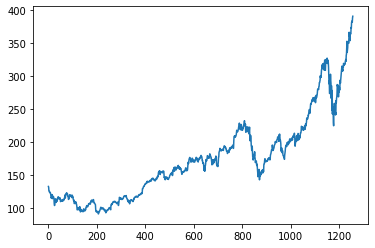

In [14]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.plot(df1)

In [15]:
### LSTM are sensitive to the scale of the data, so we apply MinMaxScaler

import numpy as np
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1=scaler.fit_transform(np.array(df1).reshape(-1,1))

In [16]:
df1.shape

(1257, 1)

In [17]:
df1

array([[0.13884083],
       [0.13444903],
       [0.11605004],
       ...,
       [0.97008917],
       [0.99111658],
       [1.        ]])

In [18]:
##splitting dataset into train and test split
training_size=int(len(df1)*0.65)
test_size=len(df1)-training_size
train_data,test_data=df1[0:training_size, :],df1[training_size:len(df1), :]
# 1st 65% of data is in training set and remaining in test

In [19]:
len(train_data),len(test_data)

(817, 440)

In [34]:
import numpy
# convert an array of values into a dataset matrix
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step)]   ###i=0, 0,1,2,3-----99   100 
        dataX.append(a)
        dataY.append(dataset[i + time_step])
    return numpy.array(dataX), numpy.array(dataY)

In [35]:
# reshape into X=t,t+1,t+2,t+3 and Y=t+4
time_step = 100
X_train, y_train = create_dataset(train_data, time_step)
X_test, ytest = create_dataset(test_data, time_step)

In [36]:
print(X_train.shape), print(y_train.shape)

(716, 100, 1)
(716, 1)


(None, None)

In [37]:
print(X_test.shape), print(ytest.shape)

(339, 100, 1)
(339, 1)


(None, None)

In [38]:
# reshape input to be [samples, time steps, features] which is required for LSTM
X_train = X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

In [29]:
X_train.shape

(716, 100, 1)

In [30]:
X_test.shape

(339, 100, 1)

In [43]:
### Create the Stacked LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [47]:
len(X_train[0])

100

In [48]:
model=Sequential()
model.add(LSTM(50,return_sequences=True,input_shape=(100,1))) # 100 coz 100 data is present in one array
model.add(LSTM(50,return_sequences=True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error',optimizer='adam')

In [49]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_3 (LSTM)                (None, 100, 50)           10400     
_________________________________________________________________
lstm_4 (LSTM)                (None, 100, 50)           20200     
_________________________________________________________________
lstm_5 (LSTM)                (None, 50)                20200     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 51        
Total params: 50,851
Trainable params: 50,851
Non-trainable params: 0
_________________________________________________________________


In [50]:
model.fit(X_train,y_train,validation_data=(X_test,ytest),epochs=100,batch_size=64,verbose=1)

Epoch 1/100
12/12 [==============================] - 2s 193ms/step - loss: 0.0106 - val_loss: 0.0500
Epoch 2/100
12/12 [==============================] - 3s 250ms/step - loss: 0.0029 - val_loss: 0.0030
Epoch 3/100
12/12 [==============================] - 1s 119ms/step - loss: 7.2290e-04 - val_loss: 0.0067
Epoch 4/100
12/12 [==============================] - 2s 185ms/step - loss: 5.7734e-04 - val_loss: 0.0030
Epoch 5/100
12/12 [==============================] - 2s 176ms/step - loss: 4.4387e-04 - val_loss: 0.0033
Epoch 6/100
12/12 [==============================] - 1s 110ms/step - loss: 4.1862e-04 - val_loss: 0.0033
Epoch 7/100
12/12 [==============================] - 3s 249ms/step - loss: 4.4286e-04 - val_loss: 0.0031
Epoch 8/100
12/12 [==============================] - 3s 250ms/step - loss: 4.4955e-04 - val_loss: 0.0034
Epoch 9/100
12/12 [==============================] - 3s 249ms/step - loss: 4.3266e-04 - val_loss: 0.0033
Epoch 10/100
12/12 [==============================] - 2s 156ms/

12/12 [==============================] - 3s 247ms/step - loss: 1.5551e-04 - val_loss: 8.9578e-04
Epoch 79/100
12/12 [==============================] - 3s 250ms/step - loss: 1.6965e-04 - val_loss: 0.0012
Epoch 80/100
12/12 [==============================] - 3s 246ms/step - loss: 1.6872e-04 - val_loss: 9.0619e-04
Epoch 81/100
12/12 [==============================] - 3s 246ms/step - loss: 1.6515e-04 - val_loss: 0.0016
Epoch 82/100
12/12 [==============================] - 3s 247ms/step - loss: 1.6886e-04 - val_loss: 8.2693e-04
Epoch 83/100
12/12 [==============================] - 3s 252ms/step - loss: 1.3700e-04 - val_loss: 8.1333e-04
Epoch 84/100
12/12 [==============================] - 3s 255ms/step - loss: 1.3583e-04 - val_loss: 0.0011
Epoch 85/100
12/12 [==============================] - 3s 249ms/step - loss: 1.2835e-04 - val_loss: 8.3759e-04
Epoch 86/100
12/12 [==============================] - 3s 251ms/step - loss: 1.2606e-04 - val_loss: 7.7003e-04
Epoch 87/100
12/12 [===============

In [51]:
import tensorflow as tf
tf.__version__

'2.2.0'

In [52]:
### Lets Do the prediction and check performance metrics
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)

In [53]:
##Transformback to original form
train_predict=scaler.inverse_transform(train_predict)
test_predict=scaler.inverse_transform(test_predict)

In [54]:
### Calculate RMSE performance metrics
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train,train_predict))

147.65203287702383

In [55]:
### Test Data RMSE
math.sqrt(mean_squared_error(ytest,test_predict))

253.6952626373896

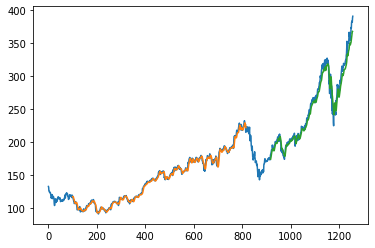

In [56]:
### Plotting 
%matplomatplotlibinline
import matplotlib.pyplot as plt

# shift train predictions for plotting
look_back=100
trainPredictPlot = numpy.empty_like(df1)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(df1)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(df1)-1, :] = test_predict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

In [57]:
len(test_data)

440

In [58]:
x_input=test_data[340:].reshape(1,-1)
x_input.shape

(1, 100)

In [59]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
temp_input

[0.6915091828586639,
 0.657905243545382,
 0.6731101943039659,
 0.6094623369709875,
 0.608929997338302,
 0.6936052701623637,
 0.6620308756986958,
 0.7066808623902051,
 0.6740085174341232,
 0.661066010114453,
 0.5850079850944904,
 0.6487889273356402,
 0.6158171413361726,
 0.5253194037796114,
 0.6242680330050574,
 0.5052901250998137,
 0.5407239819004526,
 0.5201290923609263,
 0.5138408304498271,
 0.46213734362523295,
 0.4459342560553634,
 0.5208277881288262,
 0.5163029012509982,
 0.5592893265903647,
 0.5236891136545117,
 0.547211871173809,
 0.5454817673675806,
 0.5009648655842428,
 0.5143398988554699,
 0.5026284269363854,
 0.5726976310886347,
 0.5625831780676073,
 0.5846752728240618,
 0.5910633484162897,
 0.6085640138408306,
 0.6544783071599682,
 0.6457612456747406,
 0.6532805429864255,
 0.6403380356667555,
 0.6208078253926006,
 0.5923276550439182,
 0.6180463135480438,
 0.6144862922544584,
 0.6409036465264841,
 0.6415690710673411,
 0.6262975778546713,
 0.6567407505988823,
 0.6769363854138

In [60]:
# demonstrate prediction for next 10 days
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):
    
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1
    

print(lst_output)

[0.935483]
101
1 day input [0.65790524 0.67311019 0.60946234 0.60893    0.69360527 0.66203088
 0.70668086 0.67400852 0.66106601 0.58500799 0.64878893 0.61581714
 0.5253194  0.62426803 0.50529013 0.54072398 0.52012909 0.51384083
 0.46213734 0.44593426 0.52082779 0.5163029  0.55928933 0.52368911
 0.54721187 0.54548177 0.50096487 0.5143399  0.50262843 0.57269763
 0.56258318 0.58467527 0.59106335 0.60856401 0.65447831 0.64576125
 0.65328054 0.64033804 0.62080783 0.59232766 0.61804631 0.61448629
 0.64090365 0.64156907 0.62629758 0.65674075 0.67693639 0.6611991
 0.67480703 0.68944637 0.69966063 0.71000799 0.7312683  0.74750466
 0.73552702 0.72301703 0.7293053  0.72321666 0.7473383  0.74128294
 0.76154512 0.75362656 0.76041389 0.75322731 0.75781874 0.75828454
 0.75725313 0.77026218 0.77521959 0.78114187 0.77182592 0.80236891
 0.80889007 0.84392467 0.87336971 0.81700825 0.82665691 0.84059755
 0.8708411  0.86921081 0.8696766  0.86298909 0.89343226 0.91891802
 0.89739154 0.91329518 0.87599814 0.

14 day output [[0.82968175]]
15 day input [0.50529013 0.54072398 0.52012909 0.51384083 0.46213734 0.44593426
 0.52082779 0.5163029  0.55928933 0.52368911 0.54721187 0.54548177
 0.50096487 0.5143399  0.50262843 0.57269763 0.56258318 0.58467527
 0.59106335 0.60856401 0.65447831 0.64576125 0.65328054 0.64033804
 0.62080783 0.59232766 0.61804631 0.61448629 0.64090365 0.64156907
 0.62629758 0.65674075 0.67693639 0.6611991  0.67480703 0.68944637
 0.69966063 0.71000799 0.7312683  0.74750466 0.73552702 0.72301703
 0.7293053  0.72321666 0.7473383  0.74128294 0.76154512 0.75362656
 0.76041389 0.75322731 0.75781874 0.75828454 0.75725313 0.77026218
 0.77521959 0.78114187 0.77182592 0.80236891 0.80889007 0.84392467
 0.87336971 0.81700825 0.82665691 0.84059755 0.8708411  0.86921081
 0.8696766  0.86298909 0.89343226 0.91891802 0.89739154 0.91329518
 0.87599814 0.90311419 0.9131621  0.91086638 0.91086638 0.94327256
 0.9394131  0.96829252 0.973749   0.97597817 0.97008917 0.99111658
 1.         0.935482

23 day output [[0.79660255]]
24 day input [0.52368911 0.54721187 0.54548177 0.50096487 0.5143399  0.50262843
 0.57269763 0.56258318 0.58467527 0.59106335 0.60856401 0.65447831
 0.64576125 0.65328054 0.64033804 0.62080783 0.59232766 0.61804631
 0.61448629 0.64090365 0.64156907 0.62629758 0.65674075 0.67693639
 0.6611991  0.67480703 0.68944637 0.69966063 0.71000799 0.7312683
 0.74750466 0.73552702 0.72301703 0.7293053  0.72321666 0.7473383
 0.74128294 0.76154512 0.75362656 0.76041389 0.75322731 0.75781874
 0.75828454 0.75725313 0.77026218 0.77521959 0.78114187 0.77182592
 0.80236891 0.80889007 0.84392467 0.87336971 0.81700825 0.82665691
 0.84059755 0.8708411  0.86921081 0.8696766  0.86298909 0.89343226
 0.91891802 0.89739154 0.91329518 0.87599814 0.90311419 0.9131621
 0.91086638 0.91086638 0.94327256 0.9394131  0.96829252 0.973749
 0.97597817 0.97008917 0.99111658 1.         0.93548298 0.92339289
 0.90502858 0.88750738 0.8727811  0.86111754 0.85231817 0.8459928
 0.84164286 0.83872503 0.8

In [69]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [62]:
len(df1)

1257

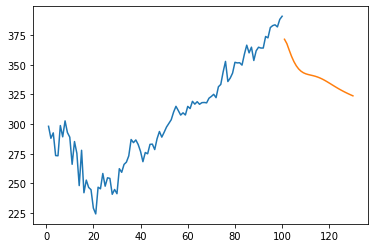

In [65]:

plt.plot(day_new,scaler.inverse_transform(df1[1157:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

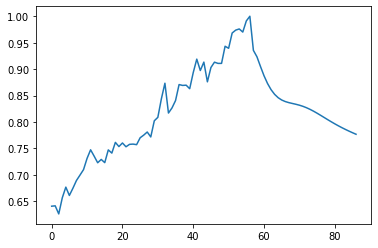

In [66]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

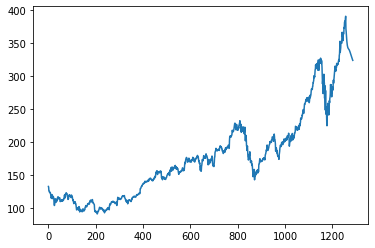

In [67]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)